In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
!pip install -U datasets
!pip install evaluate
!pip install bert_score

In [6]:
import torch
torch.manual_seed(0)
from tqdm import tqdm
from datasets import load_dataset
from torch.utils.data import DataLoader
import torch.utils.data
from timeit import default_timer as timer

# Data

## Loading Data

In [9]:
# !pip install -U datasets

In [30]:
from datasets import load_dataset

TRAIN = load_dataset("wmt16", "de-en", split="train[:50000]")
TEST = load_dataset("wmt16", "de-en", split="test[:]")
VALIDATION = load_dataset("wmt16", "de-en", split="validation[:]")

## **Dataset**

In [18]:
import torch.utils.data
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data['translation']
        self.de = []
        self.en = []

        for example in self.data:
            self.de.append(example['de'])
            self.en.append(example['en'])


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.de[idx], self.en[idx]

In [31]:
train_set = Dataset(TRAIN)
val_set = Dataset(VALIDATION)
test_set = Dataset(TEST)

#### Sanity Check

In [13]:
# TRAIN['translation'][0]

In [14]:
# val_set.de
# val_set.en
# val_set.__getitem__(0)

In [15]:
# test_set.__getitem__(0)

# Task 2B

Utilise t5-small model
to generate the translations for the validation and testing sets and report the required
evaluation metrics.

### Zero Shot

In [23]:
BATCH_SIZE = 64
from tqdm import tqdm
from torch.utils.data import DataLoader

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# task of machine translation from English to German.
def zero_shot(model, tokenizer,train_dataloader):
    output,target = [],[]
    for tgt, src in tqdm(train_dataloader):
        task_prefix = "translate English to German: "
        src = tuple(task_prefix + element for element in src)

        inputs = tokenizer([task_prefix + sentence for sentence in src], return_tensors="pt", padding=True)
        output_sequences = model.generate(
            input_ids=inputs["input_ids"].to(DEVICE),
            attention_mask=inputs["attention_mask"].to(DEVICE),
            do_sample=False,  # disable sampling to test if batching affects output
        )
        output.extend((tokenizer.batch_decode(output_sequences, skip_special_tokens=True)))
        target.extend(tgt)

    return (output), (target)

In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
tokenizer = T5Tokenizer.from_pretrained("google-t5/t5-small")
checkpoint = T5ForConditionalGeneration.from_pretrained("google-t5/t5-small")

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

### Validation Set - Zero Shot

In [ ]:
# train_iter = val_set
# train_dataloader = DataLoader(train_iter, batch_size=BATCH_SIZE)
# val_predictions, val_references = zero_shot(checkpoint,tokenizer,train_dataloader)

100%|██████████| 1/1 [00:01<00:00,  1.68s/it]


### Test Set - Zero Shot

In [ ]:
# train_iter = test_set
# train_dataloader = DataLoader(train_iter, batch_size=BATCH_SIZE)
# test_predictions, test_references = zero_shot(checkpoint,tokenizer,train_dataloader)

100%|██████████| 1/1 [00:01<00:00,  1.63s/it]


#### Sanity Check

In [ ]:
# print(val_predictions[:3], val_references[:3])

['In Tokio treffen sich die Premierminister Indiens und Japans', 'Der neue indische Premierminister Narendra Modi trifft sein japanisches Am', 'Herr Modi ist auf einer fünftägigen Reise nach Japan, um die wirtschaftliche'] ['Die Premierminister Indiens und Japans trafen sich in Tokio.', 'Indiens neuer Premierminister Narendra Modi trifft bei seinem ersten wichtigen Auslandsbesuch seit seinem Wahlsieg im Mai seinen japanischen Amtskollegen Shinzo Abe in Toko, um wirtschaftliche und sicherheitspolitische Beziehungen zu besprechen.', 'Herr Modi befindet sich auf einer fünftägigen Reise nach Japan, um die wirtschaftlichen Beziehungen mit der drittgrößten Wirtschaftsnation der Welt zu festigen.']


In [ ]:
# print(test_predictions[:3], test_references[:3])

['Obama erhält Netanjahu', 'Die Beziehung zwischen Obama und Netanjahu ist nicht gerade freundlich.', 'Die beiden wollten über die Umsetzung des internationalen Abkommens und über Teherans'] ['Obama empfängt Netanyahu', 'Das Verhältnis zwischen Obama und Netanyahu ist nicht gerade freundschaftlich.', 'Die beiden wollten über die Umsetzung der internationalen Vereinbarung sowie über Teherans destabilisierende Maßnahmen im Nahen Osten sprechen.']


#### Save Predictions

In [ ]:
# import json
# val, test = {'pred': val_predictions, 'ref': val_references}, {'pred': test_predictions, 'ref': test_references}
# dicton = {'val': val, 'test': test}

# file_path = "2B.json"
# with open(file_path, "w") as file:
#     json.dump(dicton, file)
# print("List saved to:", file_path)

List saved to: 2B.json


### EVAL - 2B

In [ ]:
# !pip install evaluate

In [ ]:
# import evaluate

# # Load the BLEU evaluator
# bleu_evaluator = evaluate.load("bleu")

# # Compute BLEU scores for validation and test sets
# val_bleu1 = bleu_evaluator.compute(predictions=val_predictions, references=val_references, max_order=1)
# test_bleu1 = bleu_evaluator.compute(predictions=test_predictions, references=test_references, max_order=1)

# val_bleu2 = bleu_evaluator.compute(predictions=val_predictions, references=val_references, max_order=2)
# test_bleu2 = bleu_evaluator.compute(predictions=test_predictions, references=test_references, max_order=2)

# val_bleu3 = bleu_evaluator.compute(predictions=val_predictions, references=val_references, max_order=3)
# test_bleu3 = bleu_evaluator.compute(predictions=test_predictions, references=test_references, max_order=3)

# val_bleu4 = bleu_evaluator.compute(predictions=val_predictions, references=val_references, max_order=4)
# test_bleu4 = bleu_evaluator.compute(predictions=test_predictions, references=test_references, max_order=4)

# print("Validation BLEU Scores:")
# print("BLEU-1:", val_bleu1)
# print("BLEU-2:", val_bleu2)
# print("BLEU-3:", val_bleu3)
# print("BLEU-4:", val_bleu4)

# print("\nTest BLEU Scores:")
# print("BLEU-1:", test_bleu1)
# print("BLEU-2:", test_bleu2)
# print("BLEU-3:", test_bleu3)
# print("BLEU-4:", test_bleu4)

Validation BLEU Scores:
BLEU-1: {'bleu': 0.264374812308888, 'precisions': [0.6890756302521008], 'brevity_penalty': 0.38366588615558134, 'length_ratio': 0.5107296137339056, 'translation_length': 119, 'reference_length': 233}
BLEU-2: {'bleu': 0.21134598441092367, 'precisions': [0.6890756302521008, 0.44036697247706424], 'brevity_penalty': 0.38366588615558134, 'length_ratio': 0.5107296137339056, 'translation_length': 119, 'reference_length': 233}
BLEU-3: {'bleu': 0.17693699891339879, 'precisions': [0.6890756302521008, 0.44036697247706424, 0.32323232323232326], 'brevity_penalty': 0.38366588615558134, 'length_ratio': 0.5107296137339056, 'translation_length': 119, 'reference_length': 233}
BLEU-4: {'bleu': 0.1496441042470567, 'precisions': [0.6890756302521008, 0.44036697247706424, 0.32323232323232326, 0.23595505617977527], 'brevity_penalty': 0.38366588615558134, 'length_ratio': 0.5107296137339056, 'translation_length': 119, 'reference_length': 233}

Test BLEU Scores:
BLEU-1: {'bleu': 0.3844073

In [ ]:
# meteor = evaluate.load("meteor")
# val_meteor = meteor.compute(predictions=val_predictions, references=val_references)
# test_meteor = meteor.compute(predictions=test_predictions, references=test_references)

# print(val_meteor, test_meteor)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


{'meteor': 0.3862362612779747} {'meteor': 0.37444319728716274}


In [ ]:
# !pip install bert_score

In [ ]:
# bertscore = evaluate.load("bertscore")

# val_bert = bertscore.compute(predictions=val_predictions, references=val_references, lang='de')
# test_bert = bertscore.compute(predictions=test_predictions, references=test_references, lang='de')

# # val_bert, test_bert

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

({'precision': [0.8879619240760803,
   0.812626838684082,
   0.8877862095832825,
   0.8868697285652161,
   0.8122455477714539,
   0.8225294947624207,
   0.8602522015571594,
   0.8306437134742737,
   0.7904727458953857,
   0.8608019948005676],
  'recall': [0.8682104349136353,
   0.6597285866737366,
   0.7509883642196655,
   0.8550117611885071,
   0.7460815906524658,
   0.8133165836334229,
   0.7225770354270935,
   0.6910619735717773,
   0.6953653693199158,
   0.7588986754417419],
  'f1': [0.8779750466346741,
   0.7282387614250183,
   0.8136776089668274,
   0.8706493973731995,
   0.7777588963508606,
   0.8178970813751221,
   0.7854270935058594,
   0.7544511556625366,
   0.7398751378059387,
   0.8066446781158447],
  'hashcode': 'bert-base-multilingual-cased_L9_no-idf_version=0.3.12(hug_trans=4.38.2)'},
 {'precision': [0.914458155632019,
   0.9650662541389465,
   0.8587332963943481,
   0.8484525084495544,
   0.9306670427322388,
   0.7882755398750305,
   0.7166427373886108,
   0.88998746871

In [ ]:
# avg_val_bert = {}

# for key in val_bert:
#     if key == "hashcode":
#         continue
#     avg_val_bert[key] = sum(val_bert[key])/len(val_bert[key])

# print(avg_val_bert)

{'precision': 0.8452190399169922, 'recall': 0.7561240375041962, 'f1': 0.7972594857215881}


In [ ]:
# avg_test_bert = {}

# for key in test_bert:
#     if key == "hashcode":
#         continue
#     avg_test_bert[key] = sum(test_bert[key])/len(test_bert[key])

# print(avg_test_bert)

{'precision': 0.8535541296005249, 'recall': 0.795784205198288, 'f1': 0.8230717122554779}


## Generate - Code Testing

In [ ]:
def translate(model, prompt:str):
    task_prefix = "translate English to German: "
    inputs = tokenizer([task_prefix +  prompt], return_tensors="pt", padding=True)
    output_sequences = model.generate(
        input_ids=inputs["input_ids"].to(DEVICE),
        attention_mask=inputs["attention_mask"].to(DEVICE),
        do_sample=False,  # disable sampling to test if batching affects output
    )
    return tokenizer.batch_decode(output_sequences, skip_special_tokens=True)

In [ ]:
import pandas as pd

def translate_csv(model, input_file:str, output_file:str):
    df = pd.read_csv(input_file)
    df['de'] = df['en'].apply(lambda x: translate(model, x)[0])
    df.to_csv(output_file, index=False)

In [ ]:
import csv
data = ['God is Dead','And we killed God']
filename = '2B_input.csv'

with open(filename, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['en'])  # Write the header row
    writer.writerows(zip(data))  # Write the data rows

#### Individual prompt

In [ ]:
prompt = "God is dead"
(translate(checkpoint,prompt))

['Gott ist tot']

#### Bulk(csv) prompts

In [ ]:
input_file = "2B_input.csv"
output_file = "2B_output.csv"
translate_csv(checkpoint, input_file, output_file)

# Task 2C
Fine Tuning on the train set of the data

### train_epoch and evaluate

In [ ]:
# # the following 2 hyperparameters are task-specific
# max_source_length = 512
# max_target_length = 128
# import torch
# DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# # task of machine translation from English to German.
# def train_epoch(model, tokenizer, train_dataloader, task_prefix = "translate German to English: "):
#     losses = 0
#     model.train()
#     for src, tgt in tqdm(train_dataloader):

#         encoding = tokenizer(
#             [task_prefix + sequence for sequence in src],
#             padding="longest",
#             max_length=max_source_length,
#             truncation=True,
#             return_tensors="pt",
#         )
#         target_encoding = tokenizer(
#             tgt,
#             padding="longest",
#             max_length=max_target_length,
#             truncation=True,
#             return_tensors="pt",
#         )
#         labels = target_encoding.input_ids
#         input_ids, attention_mask = encoding.input_ids, encoding.attention_mask

#         # replace padding token id's of the labels by -100 so it's ignored by the loss
#         labels[labels == tokenizer.pad_token_id] = -100
#         loss = model(input_ids=input_ids.to(DEVICE), attention_mask=attention_mask.to(DEVICE), labels=labels.to(DEVICE)).loss

#         # output_sequences = (model.generate(input_ids=input_ids.to(DEVICE), attention_mask=attention_mask.to(DEVICE)))
#         # print(f"Input : {src};\nPrediction : {tokenizer.batch_decode(output_sequences, skip_special_tokens=True)}")

#         # optimizer.zero_grad()
#         loss.backward()
#         # optimizer.step()

#         losses += loss.item()

#     return losses / len(list(train_dataloader))

# def evaluate(model, tokenizer, val_dataloader, task_prefix = "translate German to English: "):
#     model.eval()
#     losses = 0
#     for src, tgt in (val_dataloader):
#         encoding = tokenizer(
#             [task_prefix + sequence for sequence in src],
#             padding="longest",
#             max_length=max_source_length,
#             truncation=True,
#             return_tensors="pt",
#         )
#         target_encoding = tokenizer(
#             tgt,
#             padding="longest",
#             max_length=max_target_length,
#             truncation=True,
#             return_tensors="pt",
#         )
#         labels = target_encoding.input_ids
#         input_ids, attention_mask = encoding.input_ids, encoding.attention_mask

#         # replace padding token id's of the labels by -100 so it's ignored by the loss
#         labels[labels == tokenizer.pad_token_id] = -100
#         loss = model(input_ids=input_ids.to(DEVICE), attention_mask=attention_mask.to(DEVICE), labels=labels.to(DEVICE)).loss
#         losses += loss.item()
#         # print(loss.item())

#     return losses / len(list(val_dataloader))

### Loading Dataset

In [ ]:
TRAIN = load_dataset("wmt16", "de-en", split="train[:50000]")
TEST = load_dataset("wmt16", "de-en", split="test[:]")
VALIDATION = load_dataset("wmt16", "de-en", split="validation[:]")

train_set = Dataset(TRAIN)
val_set = Dataset(VALIDATION)
test_set = Dataset(TEST)

### Model Initialization

In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
tokenizer = T5Tokenizer.from_pretrained("google-t5/t5-small")
model = T5ForConditionalGeneration.from_pretrained("google-t5/t5-small")

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the last two layers
for param in model.encoder.block[-1:].parameters():
    param.requires_grad = True

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


### Datatloaders

In [ ]:
BATCH_SIZE = 16

train_iter, val_iter = train_set, val_set
train_dataloader = DataLoader(train_iter, batch_size=BATCH_SIZE)
val_dataloader = DataLoader(val_iter, batch_size=BATCH_SIZE)

### Full fine-tuning

In [ ]:
# NUM_EPOCHS = 4 # MIN == 2

# train_losses = []
# val_losses = []

# from timeit import default_timer as timer
# from tqdm import tqdm

# for epoch in (range(1, NUM_EPOCHS+1)):
#     start_time = timer()
#     train_loss = train_epoch(model, tokenizer, train_dataloader)
#     end_time = timer()
#     val_loss = evaluate(model, tokenizer, val_dataloader)

#     train_losses.append(train_loss)
#     val_losses.append(val_loss)

#     PATH = "2C.pt"
#     torch.save({
#             'epoch': NUM_EPOCHS,
#             'model_state_dict': model.state_dict(),
#             }, PATH)

#     print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))

100%|██████████| 4/4 [00:22<00:00,  5.63s/it]


Epoch: 1, Train loss: 1.263, Val loss: 0.976, Epoch time = 22.527s


100%|██████████| 4/4 [00:24<00:00,  6.08s/it]


Epoch: 2, Train loss: 1.213, Val loss: 0.976, Epoch time = 24.322s


100%|██████████| 4/4 [00:21<00:00,  5.39s/it]


Epoch: 3, Train loss: 1.205, Val loss: 0.976, Epoch time = 21.562s


100%|██████████| 4/4 [00:21<00:00,  5.47s/it]


Epoch: 4, Train loss: 1.258, Val loss: 0.976, Epoch time = 21.914s


In [ ]:
# PATH = "2C.pt"

# torch.save({
#             'epoch': NUM_EPOCHS,
#             'model_state_dict': model.state_dict(),
#             }, PATH)

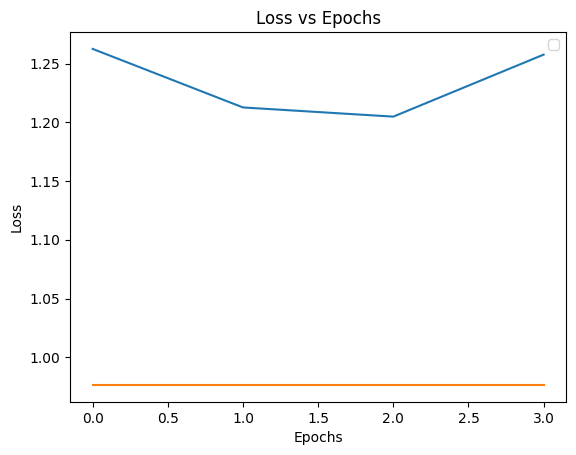

In [ ]:
# import matplotlib.pyplot as plt

# plt.plot(train_losses)
# plt.plot(val_losses)
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.title('Loss vs Epochs')
# plt.show()

# EVAL - 2C

### Load Fine-Tuned Model

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [32]:
import torch
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from transformers import T5ForConditionalGeneration, T5Tokenizer

tokenizer = T5Tokenizer.from_pretrained("google-t5/t5-small")
model = T5ForConditionalGeneration.from_pretrained("google-t5/t5-small").to(DEVICE)
model_checkpoint_path = "2C.pt"
# model_checkpoint_path = "/content/drive/MyDrive/IIITD/Courses/nlp/Assignment 3 /final_2C.pt"


checkpoint = torch.load(model_checkpoint_path, map_location=torch.device('cpu'))

model.load_state_dict(checkpoint['model_state_dict'])

model.eval()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Drop

### Test Fine-Tuned Model

In [33]:
BATCH_SIZE = 64
train_iter = val_set
train_dataloader = DataLoader(train_iter, batch_size=BATCH_SIZE)
val_predictions, val_references = zero_shot(model,tokenizer,train_dataloader)

100%|██████████| 34/34 [00:17<00:00,  1.97it/s]


In [34]:
train_iter = test_set
train_dataloader = DataLoader(train_iter, batch_size=BATCH_SIZE)
test_predictions, test_references = zero_shot(model,tokenizer,train_dataloader)

100%|██████████| 47/47 [00:24<00:00,  1.88it/s]


In [35]:
# import json
# val, test = {'pred': val_predictions, 'ref': val_references}, {'pred': test_predictions, 'ref': test_references}
# dicton = {'val': val, 'test': test}

# file_path = "2C.json"
# with open(file_path, "w") as file:
#     json.dump(dicton, file)
# print("List saved to:", file_path)

List saved to: 2C.json


### Evaluate

In [ ]:
# !pip install evaluate

In [37]:
import evaluate

# Load the BLEU evaluator
bleu_evaluator = evaluate.load("bleu")

# Compute BLEU scores for validation and test sets
val_bleu1 = bleu_evaluator.compute(predictions=val_predictions, references=val_references, max_order=1)
test_bleu1 = bleu_evaluator.compute(predictions=test_predictions, references=test_references, max_order=1)

val_bleu2 = bleu_evaluator.compute(predictions=val_predictions, references=val_references, max_order=2)
test_bleu2 = bleu_evaluator.compute(predictions=test_predictions, references=test_references, max_order=2)

val_bleu3 = bleu_evaluator.compute(predictions=val_predictions, references=val_references, max_order=3)
test_bleu3 = bleu_evaluator.compute(predictions=test_predictions, references=test_references, max_order=3)

val_bleu4 = bleu_evaluator.compute(predictions=val_predictions, references=val_references, max_order=4)
test_bleu4 = bleu_evaluator.compute(predictions=test_predictions, references=test_references, max_order=4)

print("Validation BLEU Scores:")
print("BLEU-1:", val_bleu1)
print("BLEU-2:", val_bleu2)
print("BLEU-3:", val_bleu3)
print("BLEU-4:", val_bleu4)

print("\nTest BLEU Scores:")
print("BLEU-1:", test_bleu1)
print("BLEU-2:", test_bleu2)
print("BLEU-3:", test_bleu3)
print("BLEU-4:", test_bleu4)

Validation BLEU Scores:
BLEU-1: {'bleu': 0.2600828236841529, 'precisions': [0.5814171559034573], 'brevity_penalty': 0.4473256783763342, 'length_ratio': 0.554179846362404, 'translation_length': 24528, 'reference_length': 44260}
BLEU-2: {'bleu': 0.19594776651894452, 'precisions': [0.5814171559034573, 0.33002370410125675], 'brevity_penalty': 0.4473256783763342, 'length_ratio': 0.554179846362404, 'translation_length': 24528, 'reference_length': 44260}
BLEU-3: {'bleu': 0.15392176677126235, 'precisions': [0.5814171559034573, 0.33002370410125675, 0.2123223218265564], 'brevity_penalty': 0.4473256783763342, 'length_ratio': 0.554179846362404, 'translation_length': 24528, 'reference_length': 44260}
BLEU-4: {'bleu': 0.12388498267558495, 'precisions': [0.5814171559034573, 0.33002370410125675, 0.2123223218265564, 0.14439451933211295], 'brevity_penalty': 0.4473256783763342, 'length_ratio': 0.554179846362404, 'translation_length': 24528, 'reference_length': 44260}

Test BLEU Scores:
BLEU-1: {'bleu': 0

In [38]:
meteor = evaluate.load("meteor")
val_meteor = meteor.compute(predictions=val_predictions, references=val_references)
test_meteor = meteor.compute(predictions=test_predictions, references=test_references)

print(val_meteor, test_meteor)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


{'meteor': 0.35849881537769956} {'meteor': 0.37840198623189225}


In [ ]:
# !pip install bert_score

In [39]:
bertscore = evaluate.load("bertscore")

val_bert = bertscore.compute(predictions=val_predictions, references=val_references, lang='de')
test_bert = bertscore.compute(predictions=test_predictions, references=test_references, lang='de')

# print(val_bert, test_bert)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

In [41]:
avg_val_bert = {}

for key in val_bert:
    if key == "hashcode":
        continue
    avg_val_bert[key] = sum(val_bert[key])/len(val_bert[key])

print(avg_val_bert)

{'precision': 0.8202985920571907, 'recall': 0.7605131319889334, 'f1': 0.7880993663797515}


In [42]:
avg_test_bert = {}

for key in test_bert:
    if key == "hashcode":
        continue
    avg_test_bert[key] = sum(test_bert[key])/len(test_bert[key])

print(avg_test_bert)

{'precision': 0.8293289566842983, 'recall': 0.7654230377104887, 'f1': 0.7949184092850476}


## Generate - Code Testing

In [65]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [67]:
from transformers import T5ForConditionalGeneration, T5Tokenizer

tokenizer = T5Tokenizer.from_pretrained("google-t5/t5-small")
model = T5ForConditionalGeneration.from_pretrained("google-t5/t5-small")
model_checkpoint_path = "2C.pt"
# model_checkpoint_path = "/content/drive/MyDrive/IIITD/Courses/nlp/Assignment 3 /final_2C.pt"

checkpoint = torch.load(model_checkpoint_path, map_location=torch.device('cpu'))

model.load_state_dict(checkpoint['model_state_dict'])

model.eval()
pass

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [73]:
def translate_german(model, prompt:str):
    task_prefix = "translate German to English: "
    inputs = tokenizer([task_prefix +  prompt], return_tensors="pt", padding=True)
    output_sequences = model.generate(
        input_ids=inputs["input_ids"].to(DEVICE),
        attention_mask=inputs["attention_mask"].to(DEVICE),
        do_sample=False,  # disable sampling to test if batching affects output
    )
    return tokenizer.batch_decode(output_sequences, skip_special_tokens=True)

In [74]:
import pandas as pd

def translate_german_csv(model, input_file:str, output_file:str):
    df = pd.read_csv(input_file)
    df['en'] = df['de'].apply(lambda x: translate_german(model, x)[0])
    df.to_csv(output_file, index=False)

In [75]:
prompt = "Gott ist tot"
print(translate_german(model, prompt))

['Gott ist tot']


In [57]:
import csv
data = ['Gott ist tot', 'Und wir haben Gott getotet'] # ['Gott ist tot','Und wir haben Gott getötet']
filename = '2C_input.csv'

with open(filename, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['de'])  # Write the header row
    writer.writerows(zip(data))  # Write the data rows

In [58]:
input_file = "2C_input.csv"
output_file = "2C_output.csv"
translate_german_csv(model, input_file, output_file)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1178: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
